In [53]:
from google.colab import drive 
import tensorflow as tf 
import tensorflow.keras.layers as tfl 
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip , RandomRotation
from tensorflow.keras.preprocessing import image_dataset_from_directory
from matplotlib import pyplot as plt 


In [54]:
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!unzip drive/MyDrive/Dataset.zip > /dev/null 

In [55]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
# notice that the Images are not 160 X 160 you will resize it while reading !! WOW! simple and great 
# take care that the seed  is the same to make sure that the training and validation don't overlap 

train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 922 files belonging to 2 classes.
Using 738 files for training.
Found 922 files belonging to 2 classes.
Using 184 files for validation.


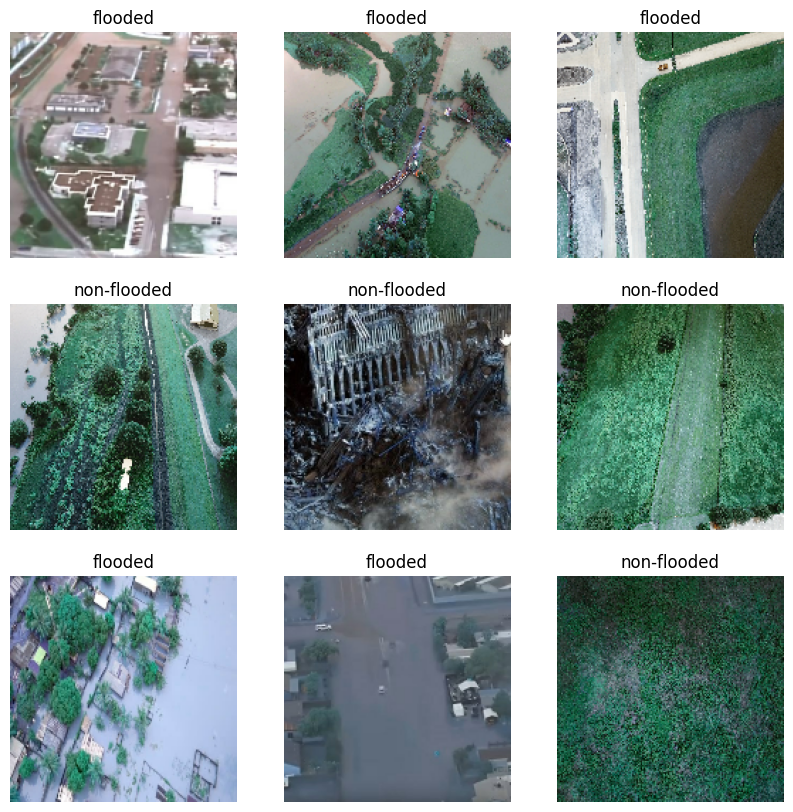

In [56]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [57]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [58]:

def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tfl.experimental.preprocessing.RandomFlip('horizontal'))
    data_augmentation.add(tfl.experimental.preprocessing.RandomRotation(0.2))

    
    return data_augmentation

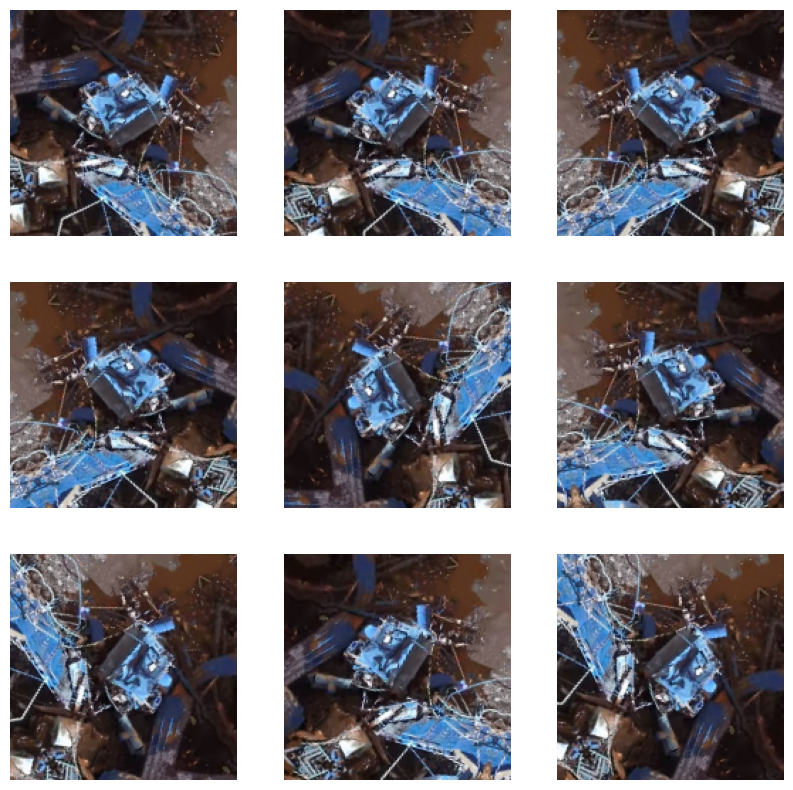

In [59]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [60]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [61]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [62]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)
print(nb_layers)

global_average_pooling2d_4
predictions
156


In [63]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [64]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

# those are the prediction of the imagenet model on our images , which is not true because the image net does not see the data related to us 
# and get top classes and their probabilites 
# the image net has 1000 class 

[[('n01484850', 'great_white_shark', 0.111576386),
  ('n02317335', 'starfish', 0.06366052)],
 [('n04325704', 'stole', 0.112228855),
  ('n02892767', 'brassiere', 0.062645644)],
 [('n02687172', 'aircraft_carrier', 0.4060509),
  ('n09428293', 'seashore', 0.034965724)],
 [('n04209239', 'shower_curtain', 0.094398096),
  ('n02687172', 'aircraft_carrier', 0.05589375)],
 [('n02807133', 'bathing_cap', 0.1804234),
  ('n09428293', 'seashore', 0.07152433)],
 [('n04147183', 'schooner', 0.2987199),
  ('n04347754', 'submarine', 0.09865559)],
 [('n03930313', 'picket_fence', 0.19696565),
  ('n03874599', 'padlock', 0.12949392)],
 [('n02966687', "carpenter's_kit", 0.077505104),
  ('n04049303', 'rain_barrel', 0.06356436)],
 [('n02687172', 'aircraft_carrier', 0.2692861),
  ('n02690373', 'airliner', 0.06517308)],
 [('n03733281', 'maze', 0.17873895), ('n04355338', 'sundial', 0.17332326)],
 [('n09193705', 'alp', 0.19600482),
  ('n13052670', 'hen-of-the-woods', 0.1324149)],
 [('n02687172', 'aircraft_carrier', 

In [65]:

def flood_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x,mask=None, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # it is instead of flatten 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1)(x)
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [66]:
model2 = flood_model(IMG_SIZE, data_augmentation)

In [67]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [68]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
24/24 [==============================] - 41s 1s/step - loss: 0.6687 - accuracy: 0.6382 - val_loss: 0.4088 - val_accuracy: 0.7772
Epoch 2/5
24/24 [==============================] - 36s 1s/step - loss: 0.3265 - accuracy: 0.8388 - val_loss: 0.2953 - val_accuracy: 0.8750
Epoch 3/5
24/24 [==============================] - 39s 1s/step - loss: 0.2485 - accuracy: 0.8848 - val_loss: 0.2520 - val_accuracy: 0.8967
Epoch 4/5
24/24 [==============================] - 34s 1s/step - loss: 0.2227 - accuracy: 0.9079 - val_loss: 0.2211 - val_accuracy: 0.9022
Epoch 5/5
24/24 [==============================] - 36s 1s/step - loss: 0.1864 - accuracy: 0.9282 - val_loss: 0.2026 - val_accuracy: 0.9076


In [75]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss

[0.408769816160202,
 0.29532289505004883,
 0.25203737616539,
 0.22110360860824585,
 0.2026180624961853]

In [70]:
# UNQ_C3
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(0.1*base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


In [71]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
24/24 [==============================] - 44s 992ms/step - loss: 0.2670 - accuracy: 0.9011 - val_loss: 0.1468 - val_accuracy: 0.9348
Epoch 6/10
24/24 [==============================] - 38s 1s/step - loss: 0.1852 - accuracy: 0.9295 - val_loss: 0.1265 - val_accuracy: 0.9674
Epoch 7/10
24/24 [==============================] - 38s 1s/step - loss: 0.1042 - accuracy: 0.9634 - val_loss: 0.1087 - val_accuracy: 0.9565
Epoch 8/10
24/24 [==============================] - 45s 1s/step - loss: 0.1105 - accuracy: 0.9593 - val_loss: 0.1541 - val_accuracy: 0.9565
Epoch 9/10
24/24 [==============================] - 33s 971ms/step - loss: 0.0814 - accuracy: 0.9770 - val_loss: 0.0596 - val_accuracy: 0.9728
Epoch 10/10


KeyboardInterrupt: ignored

In [77]:
model2.save("model2.h5")